In [136]:
from reconstruct import reconstruct_single
from dataset import CoordinateArrayDataset
from utils import rectify_pixel_values
from model import MLP

import torch
import numpy as np
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt

from pathlib import Path
import cv2

# from tqdm import tqdm

In [141]:
# taken from reconstruct for modification

def evaluate_model(checkpoint, n_x, n_y, x_lims, y_lims, batch_size=256):
  dataset = CoordinateArrayDataset(n_x, n_y, x_lims, y_lims,
                                   encoding_config=checkpoint["feature_encoding_config"])
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  model = MLP(**checkpoint["model_args"])
  model.load_state_dict(checkpoint["model_state"])
  model.cuda()
  out_shape = (n_y, n_x)
  collect = []
  for batch in dataloader:
    with torch.no_grad():
        collect.append(model(batch["features"].cuda()).detach().cpu().numpy())

  collect = np.concatenate(collect, axis=0)
  output = rectify_pixel_values(collect, mode=checkpoint["output_mode"], target_shape=out_shape)
  return output


def reconstruct_single(checkpoint, hallucination_buffer=None, scale_factor=None):
  if isinstance(checkpoint, Path) or isinstance(checkpoint, str):
    checkpoint = torch.load(checkpoint, map_location=torch.device("cpu"))
  if hallucination_buffer is None:
    hallucination_buffer = 0
  n_y, n_x = checkpoint["source_image_size"]
  if scale_factor is not None:
      n_y = int(round(n_y * scale_factor))
      n_x = int(round(n_x * scale_factor))
  # get the amount of original image range per pixel
  fac_y = 1.0 / n_y
  fac_x = 1.0 / n_x
  # extend in all directions by hallucination_buffer
  y_lims = (0.0 - fac_y * hallucination_buffer, 1.0 + fac_y * hallucination_buffer)
  x_lims = (0.0 - fac_x * hallucination_buffer, 1.0 + fac_x * hallucination_buffer)
  n_y += 2 * hallucination_buffer
  n_x += 2 * hallucination_buffer
  return evaluate_model(checkpoint, n_x, n_y, x_lims, y_lims)

In [20]:
(torch.randn(1000) * (1e-3)**0.5).numpy().var()

0.00101455

In [47]:
checkpoint_path = "/shed/data/mlp_image_reconstruction_checkpoints/mabel_ithaca_experiment_256x5/checkpoint_00299.pt"



def produce_corrupted(checkpoint_path, layer_ind, noise_vector=None,
                      noise_sigma=None, hallucination_buffer=100):
    checkpoint = torch.load(checkpoint_path)
    key = f"net.{layer_ind * 2}.bias"
    existing = checkpoint["model_state"][key]
    size = existing.shape
    dtype = existing.type()
    if noise_vector is None:
        noise_vector = torch.randn(*size, device=existing.device) * (noise_sigma ** 0.5)
    checkpoint["model_state"][key] += noise_vector
    return reconstruct_single(checkpoint, hallucination_buffer)

In [68]:
outputs = {}
outputs["baseline"] = produce_corrupted(checkpoint_path, 0, noise_sigma=0.0)

In [83]:
sigmas = [1, 0.5, 0.1, 0.01, 0.001]
layer_inds = [0, 1, 2, 3, 4]

for sigma in sigmas:
    for layer_ind in layer_inds:
        key = f"layer_{layer_ind:02d}_sigma_{sigma:.1e}"
        if key in outputs:
            continue
        outputs[key] = produce_corrupted(checkpoint_path, layer_ind, noise_sigma=sigma)

In [85]:
outputs.keys()

dict_keys(['baseline', 'layer_00_sigma_1.0e-01', 'layer_01_sigma_1.0e-01', 'layer_00_sigma_1.0e-02', 'layer_01_sigma_1.0e-02', 'layer_00_sigma_1.0e-03', 'layer_01_sigma_1.0e-03', 'layer_00_sigma_1.0e+00', 'layer_01_sigma_1.0e+00', 'layer_02_sigma_1.0e+00', 'layer_03_sigma_1.0e+00', 'layer_04_sigma_1.0e+00', 'layer_00_sigma_5.0e-01', 'layer_01_sigma_5.0e-01', 'layer_02_sigma_5.0e-01', 'layer_03_sigma_5.0e-01', 'layer_04_sigma_5.0e-01', 'layer_02_sigma_1.0e-01', 'layer_03_sigma_1.0e-01', 'layer_04_sigma_1.0e-01', 'layer_02_sigma_1.0e-02', 'layer_03_sigma_1.0e-02', 'layer_04_sigma_1.0e-02', 'layer_02_sigma_1.0e-03', 'layer_03_sigma_1.0e-03', 'layer_04_sigma_1.0e-03'])

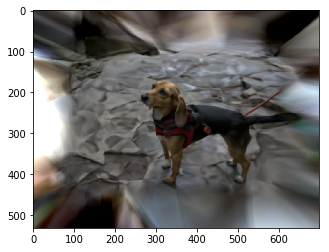

In [71]:
plt.imshow(outputs["baseline"])

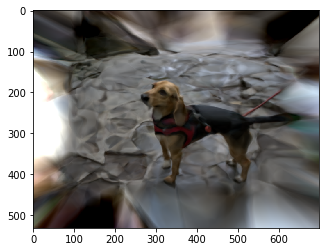

In [103]:
plt.imshow(outputs["layer_01_sigma_1.0e-02"])

### Sampling many variants with perturbations

In [108]:
n_results = 20
layer_ind = 0
sigma = 1e-2
output_dir = Path("/shed/data/mlp_image_reconstruction_output/mabel_ithaca_experiment_256x5_corruption_experiment/")
output_dir = output_dir.joinpath("multiples", f"layer_{layer_ind:02d}_sigma_{sigma:.1e}".replace(".", "p"))
output_dir.mkdir(parents=True, exist_ok=True)

for ind in range(n_results):
    output = produce_corrupted(checkpoint_path, layer_ind, noise_sigma=sigma)
    output_path = output_dir.joinpath(f"{ind:04d}.png")
    cv2.imwrite(str(output_path), cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

### Interpolating between multiple noise vectors

In [145]:
n_vectors = 8
n_steps = 30
layer_ind = 2
sigma = 1e-2

cycle = True
n_units = 256
interp_steps = np.linspace(0.0, 1.0, n_steps)


for layer_ind in range(3):
    output_dir = Path("/shed/data/mlp_image_reconstruction_output/mabel_ithaca_experiment_256x5_corruption_experiment/")
    output_dir = output_dir.joinpath("interpolation", f"layer_{layer_ind:02d}_sigma_{sigma:.1e}".replace(".", "p"))
    output_dir.mkdir(parents=True, exist_ok=True)

    vectors = []

    for ind in range(n_vectors):
        vectors.append(torch.randn(n_units) * (sigma ** 0.5))

    if cycle:
        vectors.append(vectors[0].clone().detach())


    for stage_ind, (vec_a, vec_b) in enumerate(zip(vectors, vectors[1:])):
        for step_ind, alpha in enumerate(interp_steps):
            vec = vec_a * (1 - alpha) + vec_b * alpha
            output = produce_corrupted(checkpoint_path, layer_ind, noise_vector=vec.to("cuda"))
            output_path = output_dir.joinpath(f"stage_{stage_ind:02d}_step_{step_ind:04d}.png")
            cv2.imwrite(str(output_path), cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
# send to gpu

In [133]:
vectors[0].clone().detach()

tensor([-0.0075, -0.0669,  0.0073, -0.0667, -0.0803, -0.1183,  0.0682,  0.1501,
         0.2956, -0.1638, -0.0188, -0.0291, -0.1885,  0.1885, -0.0450,  0.0673,
         0.1165,  0.0421,  0.1606,  0.0786,  0.0289, -0.0824, -0.0477,  0.2654,
         0.0143,  0.0644, -0.0336, -0.0661,  0.0770, -0.0332,  0.1420,  0.0028,
        -0.0142, -0.1027,  0.0520, -0.0572,  0.0795, -0.0620,  0.0794,  0.1422,
         0.0246,  0.0128,  0.0971, -0.1183, -0.2125, -0.0409,  0.0107, -0.1288,
        -0.0559, -0.2671,  0.0078,  0.0909, -0.0526, -0.0455, -0.1261, -0.0034,
         0.0115, -0.1589, -0.1553, -0.1224,  0.1801, -0.0858,  0.0352, -0.0119,
         0.0044,  0.0961, -0.1052, -0.0499, -0.2251,  0.0137,  0.0999, -0.1378,
         0.0476,  0.0482,  0.0115, -0.0884, -0.0409,  0.0071,  0.0267, -0.0434,
         0.1442,  0.0218, -0.0247,  0.0496,  0.0502, -0.0846,  0.0335,  0.1161,
         0.0263, -0.1205, -0.1425,  0.0284, -0.0028, -0.1833,  0.0349, -0.0669,
        -0.1231,  0.0760,  0.1500, -0.03

In [116]:
np.linspace(0.0, 1.0, n_steps).size

20

## TODO

- make into script, experiment with interpolate in fewer stages (say - 3), but with more steps so it's slow and less chaotic
- [make gif](https://engineering.giphy.com/how-to-make-gifs-with-ffmpeg/)

In [147]:
n_vectors = 2
n_steps = 240
sigma = 1e-2

cycle = False
n_units = 256
interp_steps = np.linspace(0.0, 1.0, n_steps)


for layer_ind in range(3):
    output_dir = Path("/shed/data/mlp_image_reconstruction_output/mabel_ithaca_experiment_256x5_corruption_experiment/")
    output_dir = output_dir.joinpath("interpolation_to_zero", f"layer_{layer_ind:02d}_sigma_{sigma:.1e}".replace(".", "p"))
    output_dir.mkdir(parents=True, exist_ok=True)

    vectors = []

    for ind in range(n_vectors):
        vectors.append(torch.randn(n_units) * (sigma ** 0.5))
        
    vectors[-1] = torch.zeros_like(vectors[-1])

    if cycle:
        vectors.append(vectors[0].clone().detach())


    for stage_ind, (vec_a, vec_b) in enumerate(zip(vectors, vectors[1:])):
        for step_ind, alpha in enumerate(interp_steps):
            vec = vec_a * (1 - alpha) + vec_b * alpha
            output = produce_corrupted(checkpoint_path, layer_ind, noise_vector=vec.to("cuda"))
            output_path = output_dir.joinpath(f"stage_{stage_ind:02d}_step_{step_ind:04d}.png")
            cv2.imwrite(str(output_path), cv2.cvtColor(output, cv2.COLOR_RGB2BGR))

# 